**This notebook is an exercise in the [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/overfitting-and-underfitting).**

---


# Introduction #

In this exercise, you’ll learn how to improve training outcomes by including an early stopping callback to prevent overfitting.

When you're ready, run this next cell to set everything up!

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.deep_learning_intro.ex4 import *

/tmp/ipykernel_25/1500229236.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


First load the *Spotify* dataset. Your task will be to predict the popularity of a song based on various audio features, like `'tempo'`, `'danceability'`, and `'mode'`.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('../input/dl-course-data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

2024-06-02 05:49:43.816679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 05:49:43.816785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 05:49:43.921940: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Input shape: [18]


Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the *Spotify* dataset.

I0000 00:00:1717307396.646694      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Minimum Validation Loss: 0.1936


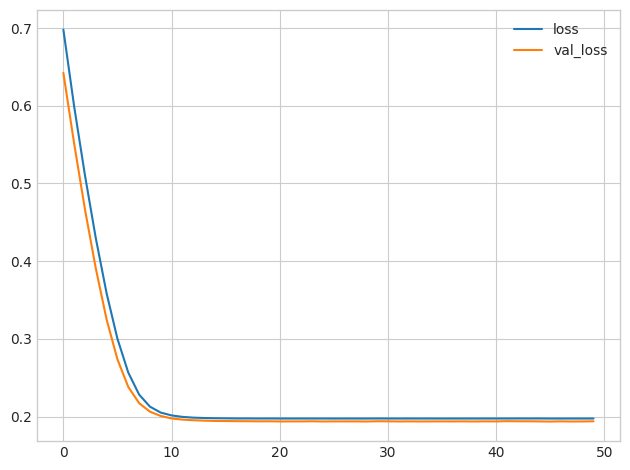

In [3]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1936


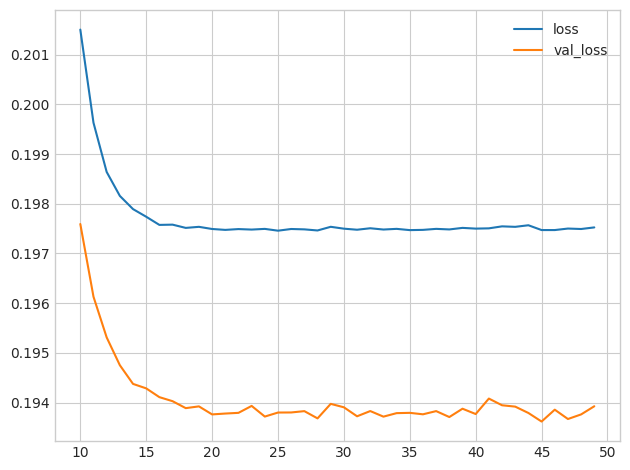

In [4]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Evaluate Baseline

What do you think? Would you say this model is underfitting, overfitting, just right?

The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. Run the next cell to train the network and see the learning curves.

Epoch 1/50
48/48 [==============================] - 2s 6ms/step - loss: 0.2206 - val_loss: 0.2015
Epoch 2/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1996 - val_loss: 0.1977
Epoch 3/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1956 - val_loss: 0.1948
Epoch 4/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1930 - val_loss: 0.1964
Epoch 5/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1906 - val_loss: 0.1943
Epoch 6/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1890 - val_loss: 0.1950
Epoch 7/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1879 - val_loss: 0.1952
Epoch 8/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1865 - val_loss: 0.1938
Epoch 9/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1853 - val_loss: 0.1937
Epoch 10/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1855 - val_loss: 0.1937
Epoch 11/50
48/48 [

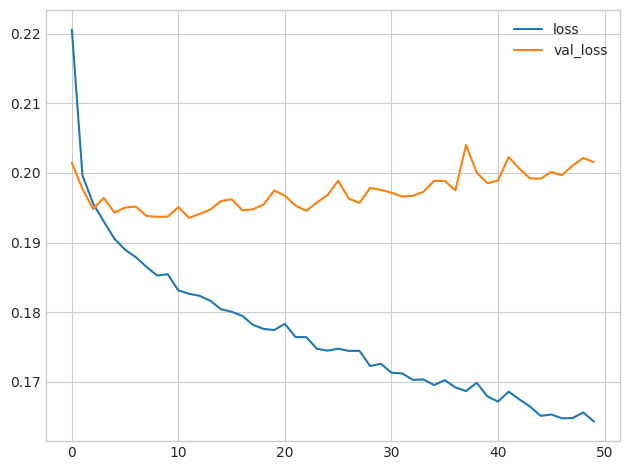

In [5]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Add Capacity

What is your evaluation of these curves? Underfitting, overfitting, just right?

Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping.

# 3) Define Early Stopping Callback

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

#define an early stopping callback
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

Now run this cell to train the model and get the learning curves. Notice the `callbacks` argument in `model.fit`.

Epoch 1/50
48/48 [==============================] - 1s 6ms/step - loss: 0.2671 - val_loss: 0.2088
Epoch 2/50
48/48 [==============================] - 0s 4ms/step - loss: 0.2054 - val_loss: 0.2003
Epoch 3/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1988 - val_loss: 0.1982
Epoch 4/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1953 - val_loss: 0.1957
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1929 - val_loss: 0.1969
Epoch 6/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1911 - val_loss: 0.1953
Epoch 7/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1895 - val_loss: 0.1941
Epoch 8/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1883 - val_loss: 0.1943
Epoch 9/50
48/48 [==============================] - 0s 3ms/step - loss: 0.1875 - val_loss: 0.1934
Epoch 10/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1868 - val_loss: 0.1941
Epoch 11/50
48/48 [

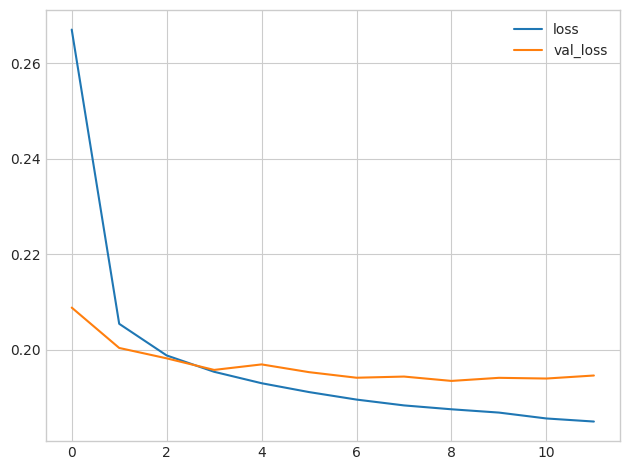

In [7]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Train and Interpret

Was this an improvement compared to training without early stopping?

The early stopping callback did stop the training once the network began overfitting. Moreover, by including restore_best_weights we still get to keep the model where validation loss was lowest.

**Experimenting with delta and patience, also comparing the curves with those scenarios:**

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

#define an early stopping callback
early_stopping = EarlyStopping(
    min_delta=0.0001, #delta changed to 0.0001
    patience=10, #patience changed to 10epochs
    restore_best_weights=True,
)



Epoch 1/50
34/34 [==============================] - 1s 7ms/step - loss: 0.2703 - val_loss: 0.2084
Epoch 2/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2062 - val_loss: 0.2020
Epoch 3/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1993 - val_loss: 0.1988
Epoch 4/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1964 - val_loss: 0.1976
Epoch 5/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1940 - val_loss: 0.1975
Epoch 6/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1924 - val_loss: 0.1967
Epoch 7/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1910 - val_loss: 0.1968
Epoch 8/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1895 - val_loss: 0.1971
Epoch 9/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1883 - val_loss: 0.1954
Epoch 10/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1874 - val_loss: 0.1965
Epoch 11/50
34/34 [

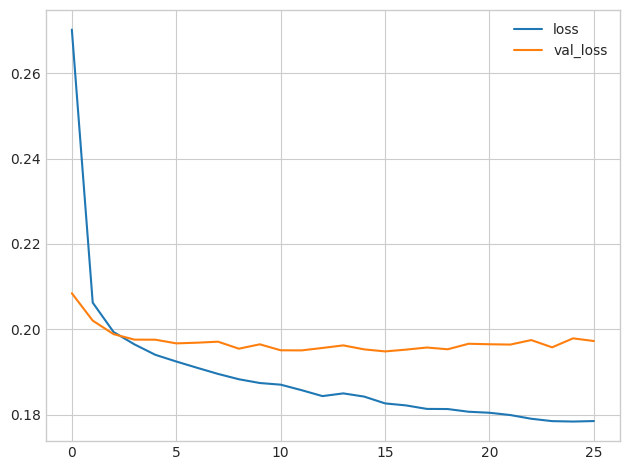

In [9]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=728, #batch size taken as 728
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

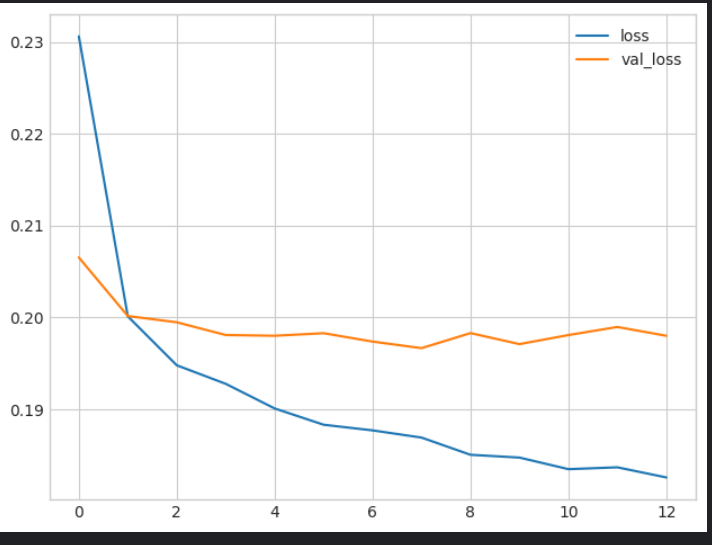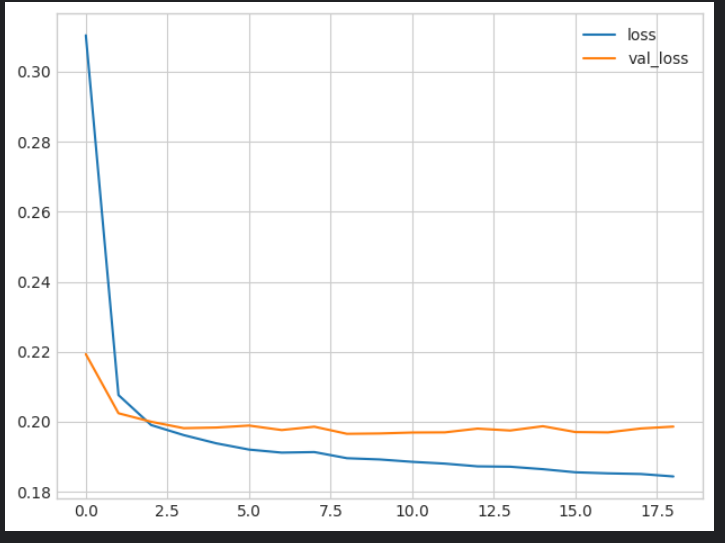

> # **To compare the two sets of loss and validation loss curves:**

# First Set (First image):
1. Loss:

* Initial loss is around 0.23.
* Decreases steeply within the first few epochs.
* Gradually continues to decrease, reaching around 0.18 by the end of the epochs.

2. Validation Loss:

* Starts around 0.21.
* Also decreases initially but not as steeply as the training loss.
* Remains relatively flat and stable after the initial drop, fluctuating slightly but generally around 0.19 to 0.20.

# Second Set (Second image):

1. Loss:

* Initial loss is higher, around 0.30.
* Decreases very steeply within the first few epochs.
* Continues to decrease and stabilizes around 0.18 by the end of the epochs.

2. Validation Loss:

* Starts at around 0.22.
* Similar to the training loss, it decreases initially but then fluctuates and stabilizes.
* Remains around 0.19 to 0.20 after the initial drop, showing a slight increase toward the end.

# Comparison:

**1. Training Loss:**

* Both sets show a similar pattern of initial steep decrease followed by a more gradual decrease.
* The second set starts with a higher loss but reaches a similar final value.

**2. Validation Loss:**

* Both sets show initial improvement, but the validation loss in both cases stabilizes around 0.19 to 0.20.
* The second set shows a slight increase in validation loss towards the end, indicating potential overfitting as the model continues to train.

**Interpretation:**

* The training loss in both sets consistently decreases, indicating that the model is learning during training.
* The validation loss stabilizes around the same value in both cases, which suggests that the model's performance on the validation data is relatively consistent.
* The second set shows a potential sign of overfitting towards the end, as indicated by the slight increase in validation loss after initial epochs.

**Improvements:**

* Early Stopping: Introducing early stopping might help in stopping the training at the point where validation loss starts to increase, preventing overfitting.
* Regularization: Applying regularization techniques could help in reducing overfitting and maintaining lower validation loss.


These observations indicate that while both models are learning, careful monitoring and additional techniques might be needed to prevent overfitting and to ensure the model generalizes well to unseen data.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-deep-learning/discussion) to chat with other learners.*